In [267]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd

from scipy import stats
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import confusion_matrix
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
from pylab import rcParams

In [268]:
respeck = pd.read_feather("respeck.feather")
# respeck.iloc[235036:235039,:]

In [269]:

respeck.drop(columns=['timestamp','activity_type','subject_id'], axis=1, inplace=True)
respeck.head(2)

,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z,activity_code
0,0.125977,-1.205872,0.143982,16.12500,6.1875,9.515625,12
1,0.104004,-0.896057,0.059509,15.46875,6.8125,18.062500,12


In [270]:
respeck = respeck.drop(235036)
respeck.isnull().values.any()
np.where(pd.isnull(respeck))

(array([], dtype=int64), array([], dtype=int64))

In [271]:

split = len(respeck)/10*7
train_respeck = respeck.loc[0:split-1,:]
test_respeck = respeck.loc[split:,:]
# print(train_respeck.loc[:,'activity_code'].drop_duplicates())
# print(test_respeck.loc[:,'activity_code'].drop_duplicates())

In [272]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
from collections import OrderedDict
def create_dataset(r, time_steps, step,train=True):
    global enc
    x_list, y_list = [], []
    # print(r.tail())
    for i in range(0, len(r) - time_steps, step):
        if(i>1):
            if(r.iloc[i,6]!=r.iloc[i-1,6]):
                # print(r.iloc[i,6])
                # print(r.iloc[i-1,6])
                continue
        v = r.iloc[i:(i + time_steps)]
        labels = v.pop('activity_code')
        
        x_list.append(v.values)
        y_list.append(stats.mode(labels)[0][0])
        # temp = r.iloc[i,6]

    print(list(OrderedDict.fromkeys(y_list)))
    x_train = np.array(x_list)
    y_train = np.array(y_list).reshape(-1, 1)
    x_train.shape

    if(train):
        enc = enc.fit(y_train)    # Call 'fit' with appropriate arguments before using this estimator.
    y_train = enc.transform(y_train)
    return (x_train,y_train)

def create_model(trainX, trainy):
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv1D(filters=256, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(100, activation='relu'))
    model.add(tf.keras.layers.Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # evaluate model
    return model

In [273]:
time_steps = 50
step = 10

x_train,y_train = create_dataset(train_respeck,time_steps, step)
print(x_train.shape)

print(y_train.shape)

model = create_model(trainX=x_train,trainy=y_train)



[12, 13, 31, 7, 2, 8, 6, 9, 11, 5, 4, 0, 100, 1]
(55417, 50, 6)
(55417, 14)


In [274]:
model.fit(x_train, y_train, epochs=30, batch_size=32, verbose=1)

Epoch 1/30
1732/1732 [==============================] - 16s 9ms/step - loss: 0.7447 - accuracy: 0.7064
Epoch 2/30
1732/1732 [==============================] - 15s 8ms/step - loss: 0.4725 - accuracy: 0.8123
Epoch 3/30
1732/1732 [==============================] - 16s 9ms/step - loss: 0.3799 - accuracy: 0.8531
Epoch 4/30
1732/1732 [==============================] - 15s 9ms/step - loss: 0.3222 - accuracy: 0.8797
Epoch 5/30
1732/1732 [==============================] - 15s 9ms/step - loss: 0.2693 - accuracy: 0.9004
Epoch 6/30
1732/1732 [==============================] - 21s 12ms/step - loss: 0.2343 - accuracy: 0.9153
Epoch 7/30
1732/1732 [==============================] - 21s 12ms/step - loss: 0.2076 - accuracy: 0.9273
Epoch 8/30
1732/1732 [==============================] - 15s 9ms/step - loss: 0.1871 - accuracy: 0.9352
Epoch 9/30
1732/1732 [==============================] - 15s 9ms/step - loss: 0.1604 - accuracy: 0.9438
Epoch 10/30
1732/1732 [==============================] - 15s 9ms/step -

In [275]:
# print(test_respeck.loc[:,'activity_code'].drop_duplicates())
x_test,y_test = create_dataset(test_respeck,time_steps, step,train = False)
print(x_test.shape)
print(y_test.shape)


[12, 13, 31, 7, 2, 8, 6, 9, 11, 5, 4, 0, 100, 1]
(27730, 50, 6)
(27730, 14)


In [276]:
results = model.evaluate(x_test, y_test, batch_size=32, verbose=0)
print("test loss, test acc:", results)

test loss, test acc: [2.4550137519836426, 0.7759105563163757]


867/867 [==============================] - 3s 3ms/step


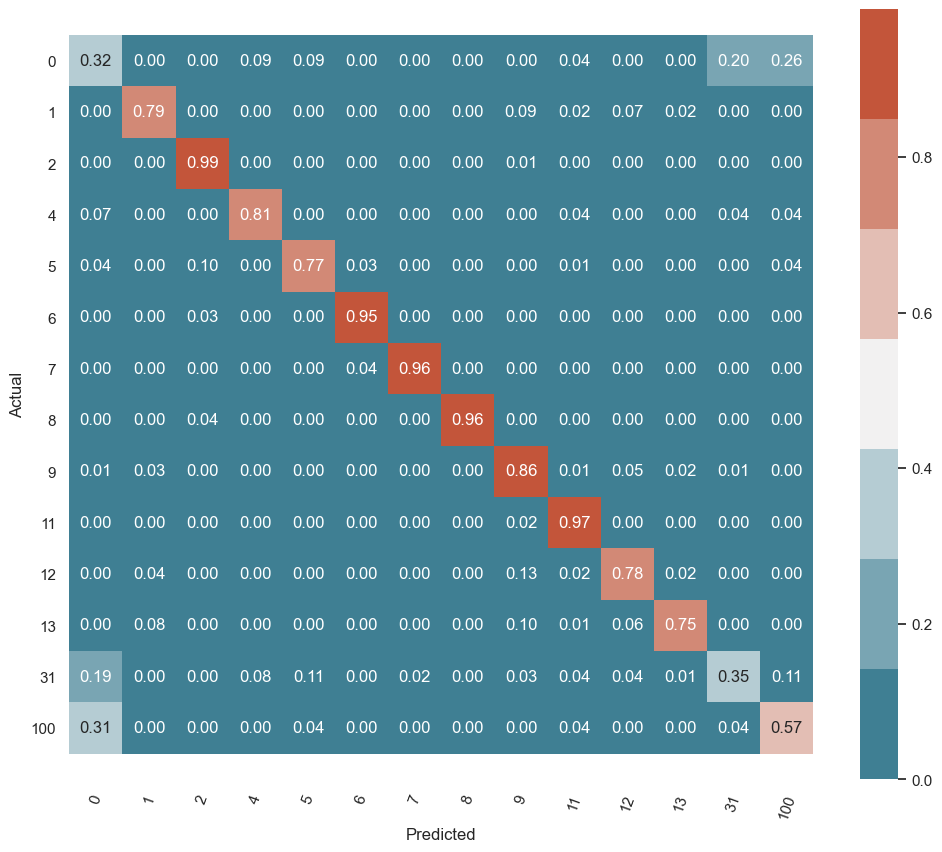

In [277]:
predy = model.predict(x_test)
# print(predy)
def plot_cm(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    fig, ax = plt.subplots(figsize=(12, 10)) 
    ax = sns.heatmap(
        cm, 
        annot=True, 
        fmt=".2f", 
        cmap=sns.diverging_palette(220, 20, n=7),
        ax=ax
    )

    plt.xticks(rotation=70)
    plt.yticks(rotation=90)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names, rotation=0)
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show() # ta-da!

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1)

rcParams['figure.figsize'] = 22, 10

plot_cm(
    enc.inverse_transform(y_test),
    enc.inverse_transform(predy),
    enc.categories_[0]
) 
# print(enc.inverse_transform(predy))
# print(enc.inverse_transform(y_test))